# Inference for Regression coefficients, Colinearity

Data 100, Summer 2023

[Acknowledgments Page](https://ds100.org/su23/acks/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm

# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=20)
%matplotlib inline


---

# The Snowy Plover

This example borrows some wording from Spring 2020's Data 100, Lecture 22.

## The Data ##
The [Snowy Plover](https://www.audubon.org/field-guide/bird/snowy-plover) is a tiny bird that lives on the coast in parts of California and elsewhere. It is so small that it is vulnerable to many predators and to people and dogs that don't look where they are stepping when they go to the beach. It is considered endangered in many parts of the US.

The data are about the eggs and newly-hatched chicks of the Snowy Plover. Here's a [parent bird and some eggs](http://cescos.fau.edu/jay/eps/articles/snowyplover.html).

![plover and eggs](images/plover_eggs.jpg)

The data were collected at the Point Reyes National Seashore by a former [student at Berkeley](https://openlibrary.org/books/OL2038693M/BLSS_the_Berkeley_interactive_statistical_system). The goal was to see how the size of an egg could be used to predict the weight of the resulting chick. The bigger the newly-hatched chick, the more likely it is to survive.

![plover and chick](images/plover_chick.jpg)

Each row of the data frame below corresponds to one Snowy Plover egg and the resulting chick. Note how tiny the bird is:

* Egg Length and Egg Breadth (widest diameter) are measured in millimeters
* Egg Weight and Bird Weight are measured in grams; for comparison, a standard paper clip weighs about one gram

In [2]:
eggs = pd.read_csv('data/snowy_plover.csv')
eggs.head()

,egg_weight,egg_length,egg_breadth,bird_weight
0,7.4,28.80,21.84,5.2
1,7.7,29.04,22.45,5.4
2,7.9,29.36,22.48,5.6
3,7.5,30.10,21.71,5.3
4,8.3,30.17,22.75,5.9


In [3]:
eggs.shape

(44, 4)

For a particular egg, $x$ is the vector of length, breadth, and weight. The model is

$$
f_{\theta}(x)  = \theta_0 + \theta_1\text{egg\_length} + \theta_2\text{egg\_breadth} + \theta_3\text{egg\_weight} + \epsilon
$$

- For each $i$, the parameter $\theta_i$ is a fixed number but it is unobservable. We can only estimate it.
- The random error $\epsilon$ is also unobservable, but it is assumed to have expectation 0 and be independent and identically distributed across eggs.

In [4]:
y = eggs["bird_weight"]
X = eggs[["egg_weight", "egg_length", "egg_breadth"]]
    
model = lm.LinearRegression(fit_intercept=True).fit(X, y)

display(pd.DataFrame([model.intercept_] + list(model.coef_),
             columns=['theta_hat'],
             index=['intercept', 'egg_weight', 'egg_length', 'egg_breadth']))

print("RMSE", np.mean((y - model.predict(X)) ** 2))

,theta_hat
intercept,-4.605670
egg_weight,0.431229
egg_length,0.066570
egg_breadth,0.215914


RMSE 0.045470853802757734


Let's try bootstrapping the sample to obtain a 95% confidence interval for the parameter $\theta_1$ corresponding to egg weight.

This code uses `df.sample` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) to generate a bootstrap sample of the same size of the original sample.

In [5]:
def get_param1(model):
    # first feature
    return model.coef_[0]

def bootstrap_params(sample_df, get_param_fn=get_param1, n_iters=10000):
    """
    sample: the bootstrap population
    """
    n = len(sample_df)
    estimates = []
    for i in range(n_iters):
        # resample n times with replacement
        # i.e., get a new sample of same size
        # using df.sample(...)
        resample = sample_df.sample(n, replace=True)
        
        # train model with this bootstrap resample
        resample_y = resample["bird_weight"]
        resample_X = resample[["egg_weight", "egg_length", "egg_breadth"]]
        model = lm.LinearRegression()
        model.fit(resample_X, resample_y)
        
        # include the estimate
        estimate = get_param_fn(model)
        estimates.append(estimate)
    lower = np.percentile(estimates, 2.5, axis=0)
    upper = np.percentile(estimates, 97.5, axis=0)
    conf_interval = (lower, upper)
    return (conf_interval, estimates)

In [6]:
approx_theta1, theta_1_hat = bootstrap_params(eggs, get_param1)
approx_theta1

(-0.25489148333439304, 1.1346303927077175)

Since the 95% confidence interval for $\theta_1$ contains $0$, we **fail to reject** the null hypothesis at cutoff 5%. In other words, our true population parameter $\theta_1$ could be 0).

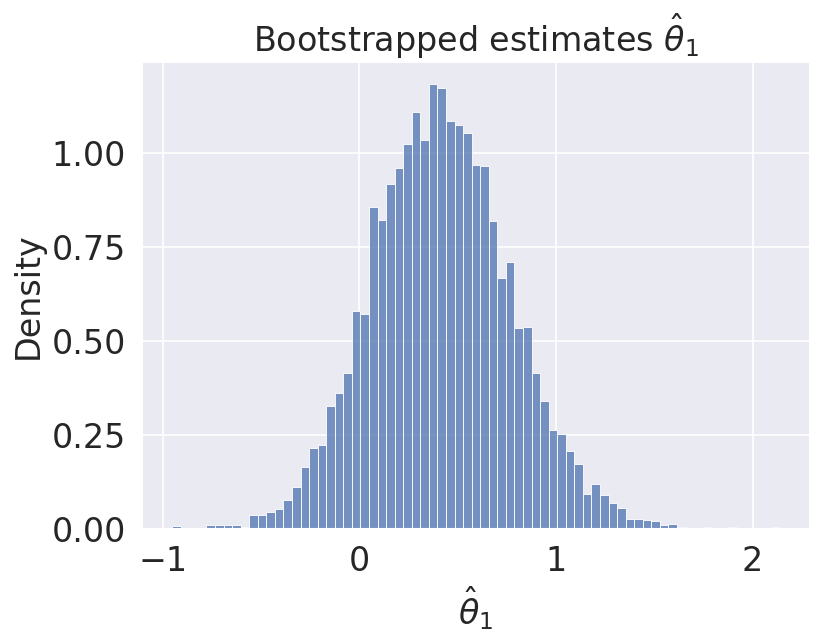

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=120)
sns.histplot(theta_1_hat, stat="density")
plt.xlabel(r"$\hat{\theta}_1$")
plt.title(r"Bootstrapped estimates $\hat{\theta}_1$");

<br/><br/>

# Testing all the coefficients

Let's bootstrap again and compute 95% confidence intervals for all 4 parameters, including the bias term:

In [8]:
def get_all_params(model):
    # all features
    return [model.intercept_] + list(model.coef_)

approx_thetas, theta_hats = bootstrap_params(eggs, get_param_fn=get_all_params)
approx_thetas

(array([-15.45006327,  -0.25594971,  -0.09781221,  -0.25844941]),
 array([5.20832913, 1.10380458, 0.2103728 , 0.75463279]))

In [9]:
pd.DataFrame(np.array([approx_thetas[0], approx_thetas[1]]).T,
             columns=['lower', 'upper'],
             index=['intercept','theta_egg_weight', 'theta_egg_length', 'theta_egg_breadth'])

,lower,upper
intercept,-15.450063,5.208329
theta_egg_weight,-0.255950,1.103805
theta_egg_length,-0.097812,0.210373
theta_egg_breadth,-0.258449,0.754633


It looks like 0 is contained in all of these confidence intervals! Does this mean all of our features are useless?



<br/><br/>

---

## Inspecting the Relationship between Features

To see what's going on, we'll make a scatter plot matrix for the data.

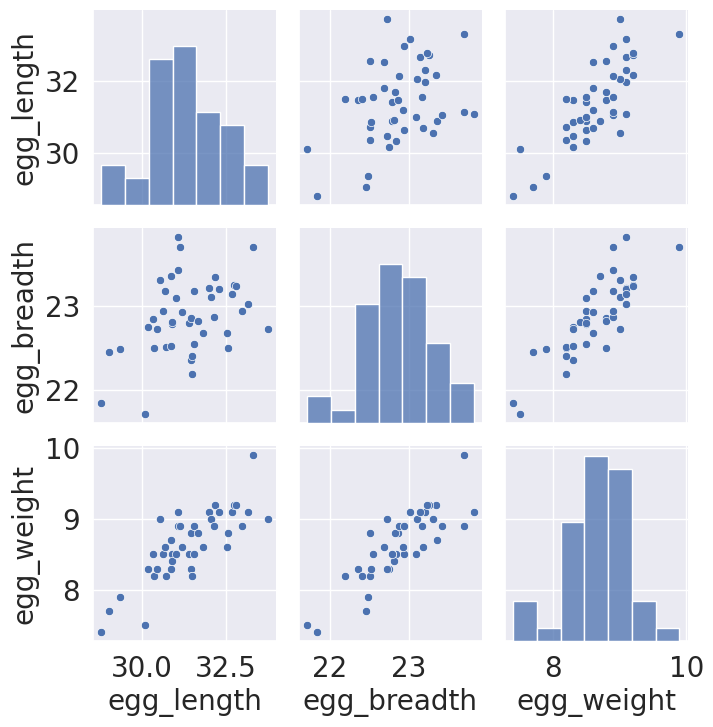

In [10]:
sns.pairplot(eggs[["egg_length", "egg_breadth", "egg_weight"]]);

This shows that `bird_weight`
is highly correlated with all the other
variables (the bottom row), which means fitting a linear model is a good idea.
But we also see that `egg_weight` is highly correlated with all the variables
(the top row).
This means we can't increase one covariate while
keeping the others constant. The individual slopes have no meaning.

Here's the correlations showing this more succinctly:

In [11]:
eggs.corr().round(2)

,egg_weight,egg_length,egg_breadth,bird_weight
egg_weight,1.00,0.79,0.84,0.85
egg_length,0.79,1.00,0.40,0.68
egg_breadth,0.84,0.40,1.00,0.73
bird_weight,0.85,0.68,0.73,1.00


<br/><br/>

---

## Changing Our Modeling Features

One way to fix this is to fit a model that only uses `egg_weight`.
This model performs almost as well as the model that uses all three variables,
and the confidence interval for $\theta_1$ doesn't 
contain zero.

In [12]:
y = eggs["bird_weight"]
X = eggs[["egg_weight"]]
    
model = lm.LinearRegression(fit_intercept=True).fit(X, y)

display(pd.DataFrame([model.intercept_] + list(model.coef_),
             columns=['theta_hat'],
             index=['intercept', 'egg_weight']))
print("RMSE", np.mean((y - model.predict(X)) ** 2))

,theta_hat
intercept,-0.058272
egg_weight,0.718515


RMSE 0.046493941375556846


In [13]:
def bootstrap_egg_weight_only(sample_df, n_iters=10000):
    """
    copied over for convenience
    """
    n = len(sample_df)
    estimates = []
    for i in range(n_iters):
        resample = sample_df.sample(n, replace=True)
        
        resample_y = resample["bird_weight"]
        resample_X = resample[["egg_weight"]] # just one feature + intercept
        model = lm.LinearRegression()
        model.fit(resample_X, resample_y)
        estimates.append( model.coef_[0])
    lower = np.percentile(estimates, 2.5, axis=0)
    upper = np.percentile(estimates, 97.5, axis=0)
    conf_interval = (lower, upper)
    return conf_interval

approx_conf_egg_weight_only = bootstrap_egg_weight_only(eggs)
approx_conf_egg_weight_only

(0.5997657176584066, 0.8201169601381006)

It's no surprise that if you want to predict the
weight of the newly-hatched chick, using the weight
of the egg is your best move.

As this example shows, checking for collinearity is important for inference.
When we fit a model on highly correlated variables, we might not be able to
use confidence intervals to conclude that variables are
related to the prediction.